In [1]:
import pandas as pd
import numpy as np
import collections

class GA():
    
    '''
    Algoritmo genetico para classificacao binaria
    
    Parameters
    ----------
    num_cromossomos: int
        numero de cromossomos que realizarao a previsao
        
    iteracao: int
        numero maximo de iteracoes

    Attributes
    ----------
    equacao_previsao: array numpy unidimensional
        armazena o resultado do treinamento
        
    '''
    
    def __init__(self, n_filhos=5, num_cromossomos=6, iteracao=500):
        self.num_cromossomos = num_cromossomos
        self.iteracao = iteracao
        self.equacao_previsao = np.zeros(num_cromossomos)
        self.n_filhos = n_filhos
    
    # Retorna numeros aleatorios entre 1 e -1
    def _gera_aleatorio(self, num_atibutos):
        return (2 * np.random.rand(num_atibutos)) - 1
   
    # multiplica os valores do dataframe pelos pesos gerados aleatoriamente
    def _gera_cromossomos(self, x, b):
        return np.sum(x * b, axis=1)
    
    # realiza o fit do cromossomo identificando o nivel de acerto
    def _fit_cromossomos(self, x, y, b):
   
        previsao = np.where( self._gera_cromossomos(x,b) < 0, 0, 1)

        total_corretos = pd.crosstab(y, previsao, dropna=False).reindex(columns=[0,1], fill_value=0)
        total_valores = dict(collections.Counter(y))

        return (total_corretos.loc[0,0] * total_corretos.loc[1,1]) / (total_valores[1] * total_valores[0])
    
    # seleciona os dois melhores cromossomos para realizar o crossover
    def _seleciona_pais(self, fc_df):
        escolhidos = np.random.rand(2)
        fc_df['total'] = fc_df['fc_cromossomo'].sum()
        fc_df['proporcao'] = fc_df['fc_cromossomo'] / fc_df['total']
        fc_df = fc_df.fillna(0)

        if(any(fc_df['proporcao'] == 1) | all(fc_df['proporcao'] == 0)):
            prop = None
        else:
            prop = fc_df['proporcao']

        return np.random.choice(fc_df.index, size=2, p=prop, replace=False)

    # com os dois melhores cromossomos gera outros tres, substituindo os dois piores cromossomos no banco de cromossos pelos
    # dois melhores gerados
    def _crossover(self, fc, bc, escolhidos, x, y):
        fc_filho = []
        bc_filho = []

        tamanho = x.shape[1]
        cross = np.random.randint(0,tamanho,self.n_filhos)

        fc_menor_indice = fc.nsmallest(2, 'fc_cromossomo').index

        for parte in cross:
            cromo_subistitui = np.random.randint(0,tamanho,2)
            cromo_ind = np.random.randint(0,6)

            filho = np.concatenate( (bc[escolhidos[0]][:parte+1], bc[escolhidos[1]][parte+1:]) )
            filho[cromo_subistitui[0]] = bc[cromo_ind][cromo_subistitui[1]]

            fc_filho.append(self._fit_cromossomos(x,y,filho))
            bc_filho.append(filho)

        bc_filho = dict(enumerate(bc_filho))
        fc_filho = pd.DataFrame.from_dict(dict(enumerate(fc_filho)), orient = 'index', columns = ['fc_cromossomo'])
        fc_filho = fc_filho.iloc[fc_filho.nlargest(2, 'fc_cromossomo').index]
                
        for i, menor in enumerate(fc_menor_indice):
            if (fc.iloc[menor].fc_cromossomo <= fc_filho.iloc[i].fc_cromossomo):
                bc[menor] = bc_filho[i]
                fc.iloc[menor] = fc_filho.iloc[i]
                
    def fit(self, x, y):
        '''
        Realiza o treinamento do algoritmo

        Parameters
        ----------
        x: numpy array
            dataset sem a variavel target com uma coluna adicional preenchida com 1 na primeira posicao

        y: numpy array
            variavel target do dataset

    '''

        banco_cromossomos = []
        banco_fit = []

        for i in range(self.num_cromossomos):
            b = self._gera_aleatorio(x.shape[1])

            fc = self._fit_cromossomos(x,y,b)

            banco_cromossomos.append(b)
            banco_fit.append(fc)

        banco_cromossomos = dict(enumerate(banco_cromossomos))
        banco_fit = pd.DataFrame.from_dict(dict(enumerate(banco_fit)), orient = 'index', columns = ['fc_cromossomo'])
        
        for i in range(self.iteracao):
               
            escolhidos = self._seleciona_pais(banco_fit.copy())
            self._crossover(banco_fit, banco_cromossomos, escolhidos, x, y)
        self.equacao_previsao = banco_cromossomos[banco_fit.nlargest(1, 'fc_cromossomo').index[0]]
    
    def predict(self, x):
        '''
        Previsoes utilizando o algoritmo genetico

        Parameters
        ----------
        x : numpy array
            dataset de entrada

        Returns
        -------
        y : list
            classes previstas
        '''
    
        y = list(map(lambda x: np.where(np.sum(x * self.equacao_previsao)< 0, 0, 1), x))
        
        return y

### Descricao

Analise preditiva de risco de credito. O algoritmo ira prever a varivel loan_status, ou seja, se o cliente é um bom pagador ou um mau pagador.

fonte: https://www.kaggle.com/laotse/credit-risk-dataset

### Bibliotecas

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

### Dataset

In [3]:
df = pd.read_csv('credit_risk_dataset.csv')

###### Colunas
- person_age:             Age
- person_income:	        Annual Income
- personhomeownership:	Home ownership
- personemplength:	    Employment length (in years)
- loan_intent:	        Loan intent
- loan_grade:	            Loan grade
- loan_amnt:	            Loan amount
- loanintrate:	        Interest rate
- loan_status:	        Loan status (0 is non default 1 is default)
- loanpercentincome:	    Percent income
- cbpersondefaultonfile:	Historical default
- cbpresoncredhistlength:	Credit history length

### Analise Exploratoria

In [4]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [5]:
df.shape

(32581, 12)

In [6]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [7]:
df.loan_status.value_counts()

0    25473
1     7108
Name: loan_status, dtype: int64

##### Variaveis categoricas

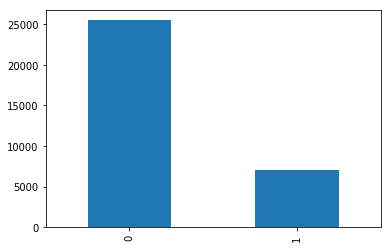

In [8]:
df.loan_status.value_counts().plot.bar()

O dataset possui mais informações a respeito de clientes adimplentes

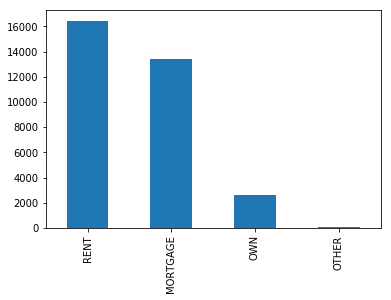

In [9]:
df.person_home_ownership.value_counts().plot.bar()

Boa parte dos clientes possui casa alugada ou hipotecada

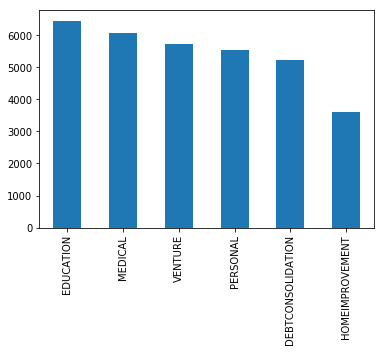

In [10]:
df.loan_intent.value_counts().plot.bar()

Apesar dos valores estarem próximos, educação é o principal motivo para obtenção de empréstimos

##### Relacao entre as váriaveis categóricas

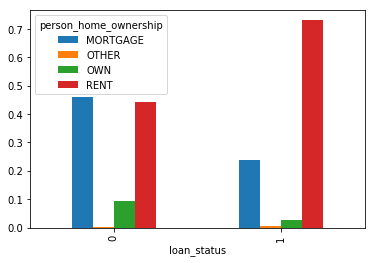

In [11]:
plot = pd.crosstab(df.loan_status, df.person_home_ownership, normalize='index')
plot.plot.bar()

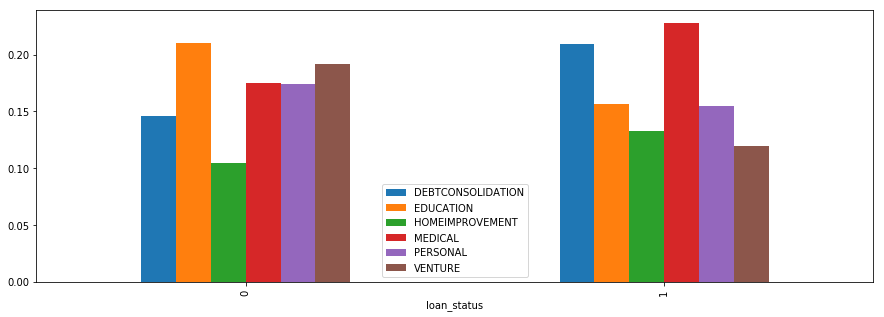

In [12]:
plot = pd.crosstab(df.loan_status, df.loan_intent, normalize='index')
plot.plot.bar(figsize=(15,5)).legend(loc='best')

##### Variaveis quantitativas

In [13]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


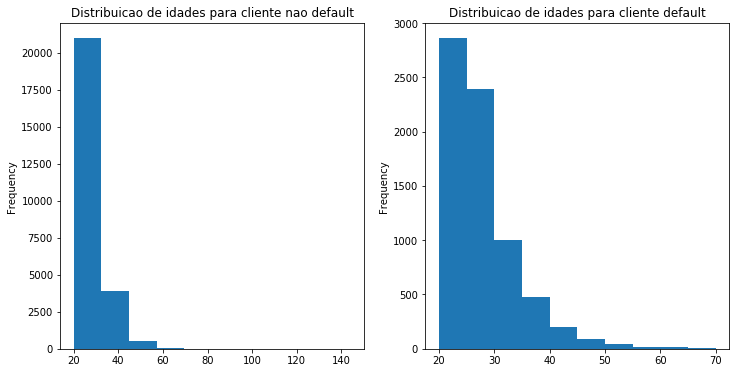

In [14]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
df[df.loan_status == 0].person_age.plot.hist(ax=axes[0], subplots=True)
df[df.loan_status == 1].person_age.plot.hist(ax=axes[1], subplots=True)

axes[0].set_title('Distribuicao de idades para cliente nao default')
axes[1].set_title('Distribuicao de idades para cliente default')

plt.show()

A maior parte dos cliente devedores possuem entre 20 e 30 anos 

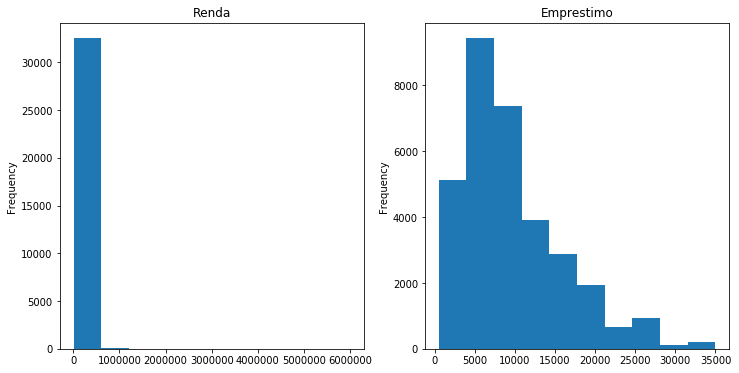

In [15]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
df.person_income.plot.hist(ax=axes[0], subplots=True)
df.loan_amnt.plot.hist(ax=axes[1], subplots=True)

axes[0].set_title('Renda')
axes[1].set_title('Emprestimo')

plt.show()

A renda esta concentrada proximo ao 0 e 500 mil. Porem existe uma pequena parcela que ganha bem mais. Já os emprétimos mais realizados estão entre 5000 e 10000

C:\Users\gabri\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\gabri\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


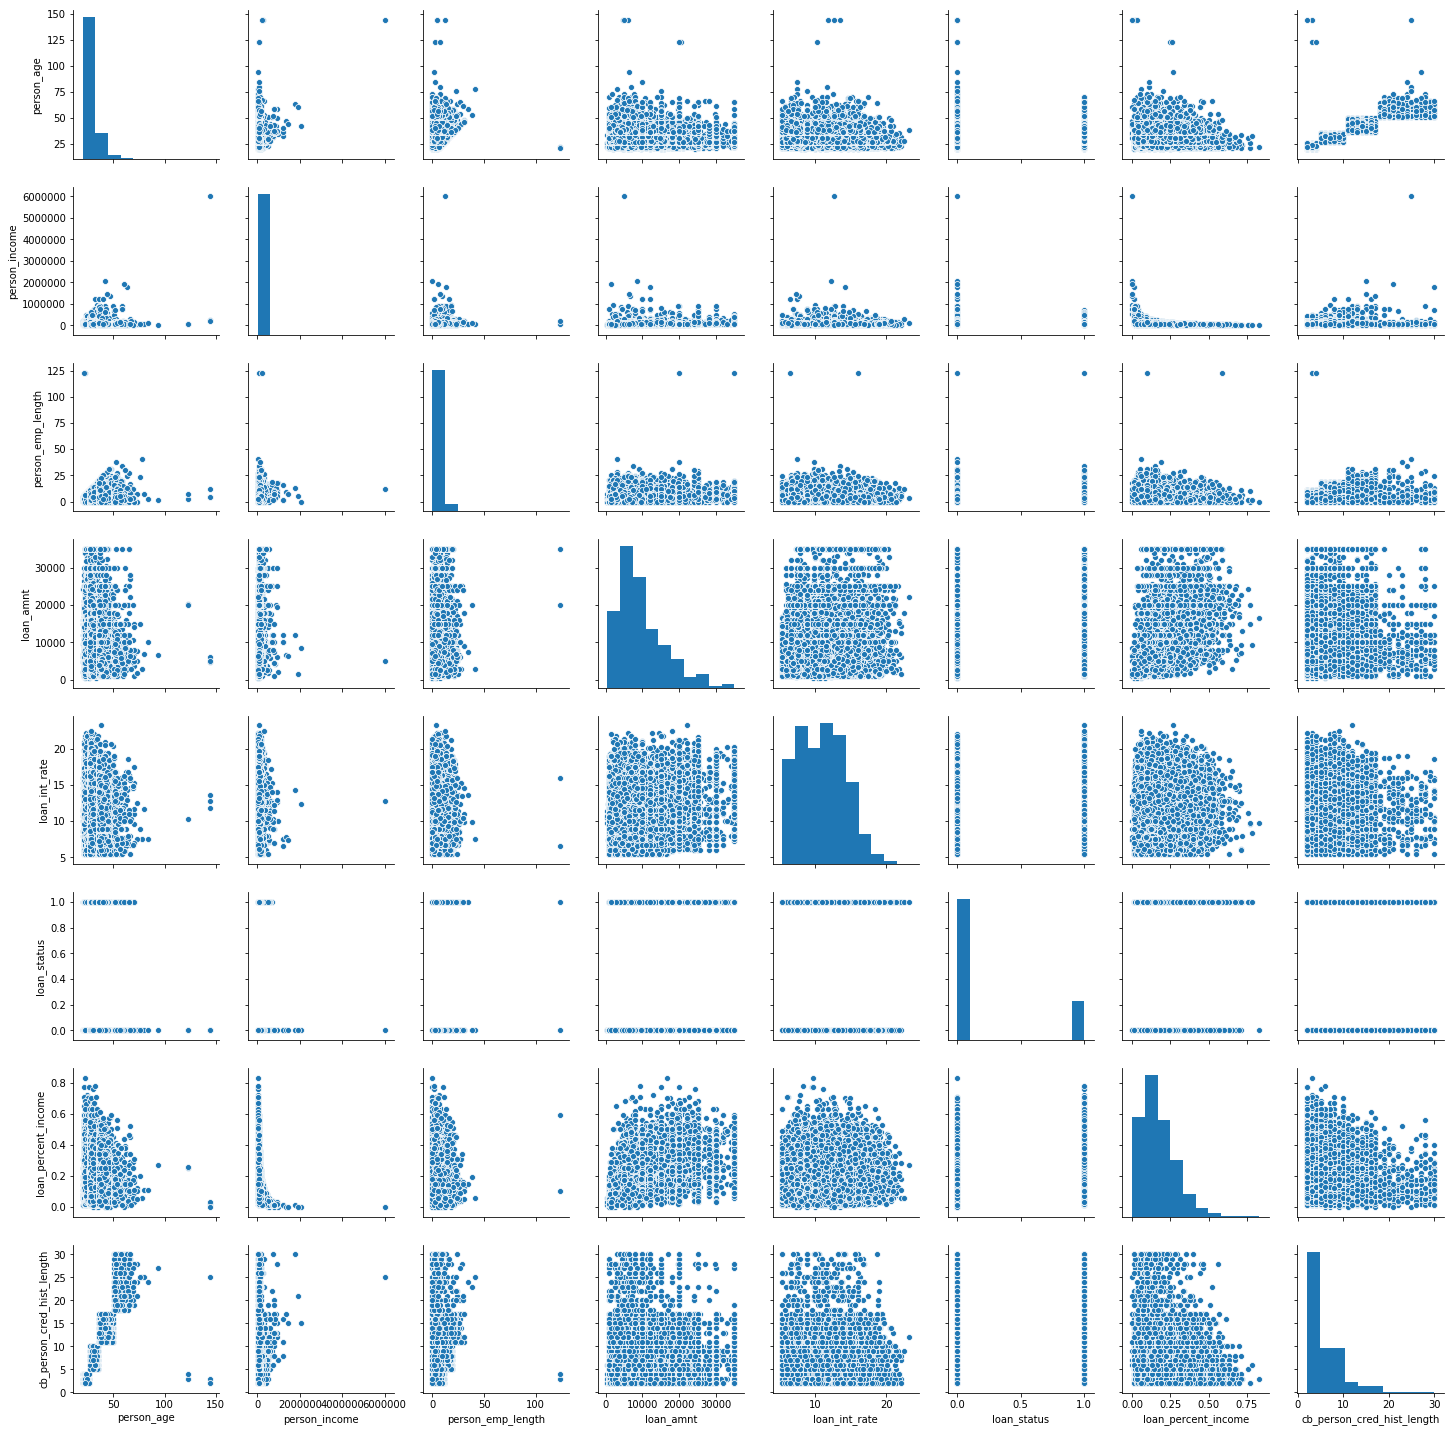

In [16]:
sns.pairplot(df)

##### Tratamento dos dados

In [17]:
# removendo outliers do tempo de empresa
df = df[df.person_emp_length <= 50]
df = df.dropna(subset=['person_emp_length'])

df = df.fillna(0)
df = df.reset_index(drop=True)

In [18]:
df.shape

(31684, 12)

In [19]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
1,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
4,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


In [20]:
X = df.drop(columns='loan_status')
y = df['loan_status']

##### Normalizacao

In [21]:
scaler = MinMaxScaler(feature_range = (0, 1))

cols = X.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(X.select_dtypes(include=['float64','int64']).values)

sc_traindf = pd.DataFrame(sc_train, columns = cols)

In [22]:
sc_traindf.shape

(31684, 7)

##### Padronizacao

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Extrair atributos numéricos e dimensioná-los para ter média zero e variação unitária
cols = sc_traindf.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(sc_traindf.select_dtypes(include=['float64','int64']))

# Transformar o resultado de volta em um dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)

In [24]:
sc_traindf.shape

(31684, 7)

##### Binarizacao

In [25]:
# Extrair atributos categóricos de conjuntos de treinament
cattrain = X.select_dtypes(include=['object']).copy()
cattrain = pd.get_dummies(cattrain, columns=X.select_dtypes(include=['object']).columns)
cattrain.shape

(31684, 19)

In [26]:
#x_dum = pd.get_dummies(X, columns=X.columns)
x_dum = pd.concat([sc_traindf, cattrain], axis=1)

In [27]:
x_dum.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,-1.060927,-0.914519,0.053974,-1.367158,0.259734,-0.654936,-0.938086,0,0,1,...,0,0,1,0,0,0,0,0,1,0
1,-0.432015,-0.914519,-0.937395,-0.656759,0.646368,3.767699,-0.691835,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,-0.746471,-0.019034,-0.193868,4.000307,1.173800,3.391304,-0.938086,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,-0.589243,-0.196849,0.797501,4.000307,0.959251,3.579501,-0.445583,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,-1.060927,-0.909713,-0.689553,-1.130359,-0.634218,0.756543,-0.938086,0,0,1,...,1,1,0,0,0,0,0,0,1,0


##### Amostragem e Balanceamento

In [28]:
# Aplicar a super amostragem aleatória
ros = RandomOverSampler()
X_res, y_res = ros.fit_resample(x_dum, y)

print('Forma original do conjunto de dados {}'.format(Counter(y)))
print('Forma de conjunto de dados reamostrada {}'.format(Counter(y_res)))

Forma original do conjunto de dados Counter({0: 24859, 1: 6825})
Forma de conjunto de dados reamostrada Counter({0: 24859, 1: 24859})


##### Separa teste e treino

In [29]:
#x_completo = pd.concat([sc_traindf, cattrain], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=42)

In [30]:
X_train.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
44268,-0.274787,-0.443548,-0.441711,0.842974,1.205088,1.979825,-0.938086,0,0,0,...,0,0,0,0,1,0,0,0,1,0
44052,1.926406,0.037034,4.019450,0.558814,0.729059,0.191951,2.016933,1,0,0,...,0,0,0,0,1,0,0,0,0,1
39201,-0.274787,-0.123160,-0.937395,0.369374,-2.229922,0.286050,-0.445583,0,0,0,...,0,0,0,0,1,0,0,0,1,0
40598,-0.274787,-0.619761,1.293185,0.527241,1.410697,2.732614,-0.691835,0,0,0,...,0,0,0,0,1,0,0,0,0,1
41883,-0.746471,-0.446752,-0.689553,0.775881,-2.229922,1.979825,-0.938086,0,0,0,...,0,1,0,0,0,0,0,0,1,0


##### Pre-processamneto para GA

In [31]:
# cria coluna para calcular b0
b0 = np.ones((X_train.shape[0],1))
X_train_ga = X_train.to_numpy()
X_train_ga = np.append(b0, X_train, axis=1)

b0 = np.ones((X_test.shape[0],1))
X_test_ga = X_test.to_numpy()
X_test_ga = np.append(b0, X_test, axis=1)

##### Treinamento do modelo

In [32]:
modelo = GA()
modelo.fit(X_train_ga,y_train)

##### Avaliacao do modelo

In [33]:
y_prev = modelo.predict(X_test_ga)
accuracy = metrics.accuracy_score(y_test, y_prev)
confusion_matrix = metrics.confusion_matrix(y_test, y_prev)
classification = metrics.classification_report(y_test, y_prev)
print()
print('============================== Avaliação do Modelo ==============================')
print()
print ("Acurácia do Modelo:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Relatório de Classificação:" "\n", classification) 


============================== Avaliação do Modelo ==============================

Acurácia do Modelo:
 0.7298104467605291

Confusion matrix:
 [[6026 2156]
 [2277 5948]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.73      0.74      0.73      8182
           1       0.73      0.72      0.73      8225

    accuracy                           0.73     16407
   macro avg       0.73      0.73      0.73     16407
weighted avg       0.73      0.73      0.73     16407

